In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.stats import pearsonr, false_discovery_control

from utils import get_expasy_peptide_mass, get_uniprotkbid

sns.set_theme(style="darkgrid")

# Load the data
Load the normalized data for the selected microdissociations

In [2]:
# load the counts data
counts = pd.read_csv("data/PDAC_MICRODISSEC_NAIF/rna_seq_selected_vst.csv", index_col=0)

# load the density data
densities = pd.read_csv("data/MALDI_IHC/microdissection_densities.csv", index_col=0)

In [3]:
# load the matirisom genes
matrisome_genes = pd.read_csv("Hs_Matrisome_Masterlist_2012.csv")

# load the gene annotation
gene_annotation = pd.read_csv("geneAnnot.tsv", sep="\t")

In [4]:
# Define the Gene_Id column in the matrisome_genes dataframe
def get_gene_id(gene_symbol, gene_annotation):
    gene_id = gene_annotation[gene_annotation["GeneName"] == gene_symbol]["GeneID"].values
    return gene_id[0] if len(gene_id) > 0 else None

matrisome_genes["Gene_Id"] = matrisome_genes["Gene Symbol"].apply(lambda x: get_gene_id(x, gene_annotation))

In [5]:
# Replace the " " by _ in the column names
matrisome_genes.columns = matrisome_genes.columns.str.replace(" ", "_")

# Clean the matrisome_genes unwanted columns
matrisome_genes = matrisome_genes.drop(columns=["Gene_Name", "Synonyms", "HGNC_IDs", "HGNC_IDs_Links", "UniProt_IDs", "Refseq_IDs", "Notes"])

# Rorder the columns
matrisome_genes = matrisome_genes[["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category"]]

In [6]:
# Remove the matrisome genes that are not in the counts data
matrisome_genes = matrisome_genes[matrisome_genes["Gene_Id"].isin(counts.index)]

In [7]:
# Clean the defects
densities = densities[densities["Defects"] < 0.1]

# Exlude the microdissected samples out of lesion
densities = densities[densities["Lesion"] > 0.5]

# Drop the columns
densities = densities.drop(["Lesion", "Defects"], axis=1)

In [8]:
# Clean the counts to include only the genes in the corr_matrisome and the microdissections in the densities
counts = counts.loc[matrisome_genes.Gene_Id,densities.index]

In [ ]:
# Compute the correlation between the counts and the densities
for density in densities.columns:
    correlations = []
    pvalues = []
    for gene in counts.index:
        corr, pvalu = pearsonr(counts.loc[gene], densities[density])
        correlations.append(corr)
        pvalues.append(pvalu)
        qvalues = false_discovery_control(ps=pvalues, method="bh")

    matrisome_genes[density] = correlations
    matrisome_genes[density + "_p"] = pvalues
    matrisome_genes[density + "_q"] = qvalues

matrisome_genes.head()

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
0,ENSG00000154175,ABI3BP,Core matrisome,ECM Glycoproteins,-0.061701,0.619886,0.995823,0.133013,0.283252,0.757606,0.020019,0.872257,0.987368,0.084211,0.498069,0.859477
1,ENSG00000181092,ADIPOQ,Core matrisome,ECM Glycoproteins,0.029012,0.815717,0.995823,0.139111,0.261559,0.744766,0.018070,0.884600,0.987368,0.083897,0.499680,0.859477
2,ENSG00000106624,AEBP1,Core matrisome,ECM Glycoproteins,0.053773,0.665612,0.995823,-0.118349,0.340157,0.800885,0.377547,0.001635,0.025688,-0.328362,0.006671,0.074343
3,ENSG00000188157,AGRN,Core matrisome,ECM Glycoproteins,-0.085639,0.490786,0.995823,-0.334142,0.005718,0.203805,-0.116310,0.348601,0.785722,0.234197,0.056452,0.278925
4,ENSG00000178522,AMBN,Core matrisome,ECM Glycoproteins,0.102685,0.408302,0.995823,0.150486,0.224161,0.721186,0.165165,0.181653,0.567595,-0.254378,0.037775,0.210489


In [10]:
# Exclude the pvalues and qvalues columns
corr_genes = matrisome_genes.drop(columns=[col for col in matrisome_genes.columns if "_p" in col] + [col for col in matrisome_genes.columns if "_q" in col])

# Melt the data to have the Staining as a column
corr_staining = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Division", "Matrisome_Category", "Gene_Symbol"],
                                var_name="Staining",
                                value_name="Correlation")

# Filter the data to have only the Tumor and Stroma staining
corr_tumor_stroma = corr_staining[corr_staining["Staining"].isin(["Tumor", "Stroma"])]

# Melt the data to have the Matrisome Division as a column
corr_division = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Category", "Gene_Symbol", "CD8", "Collagen", "Stroma", "Tumor"],
                                var_name="Matrisome_Division",
                                value_name="Division")

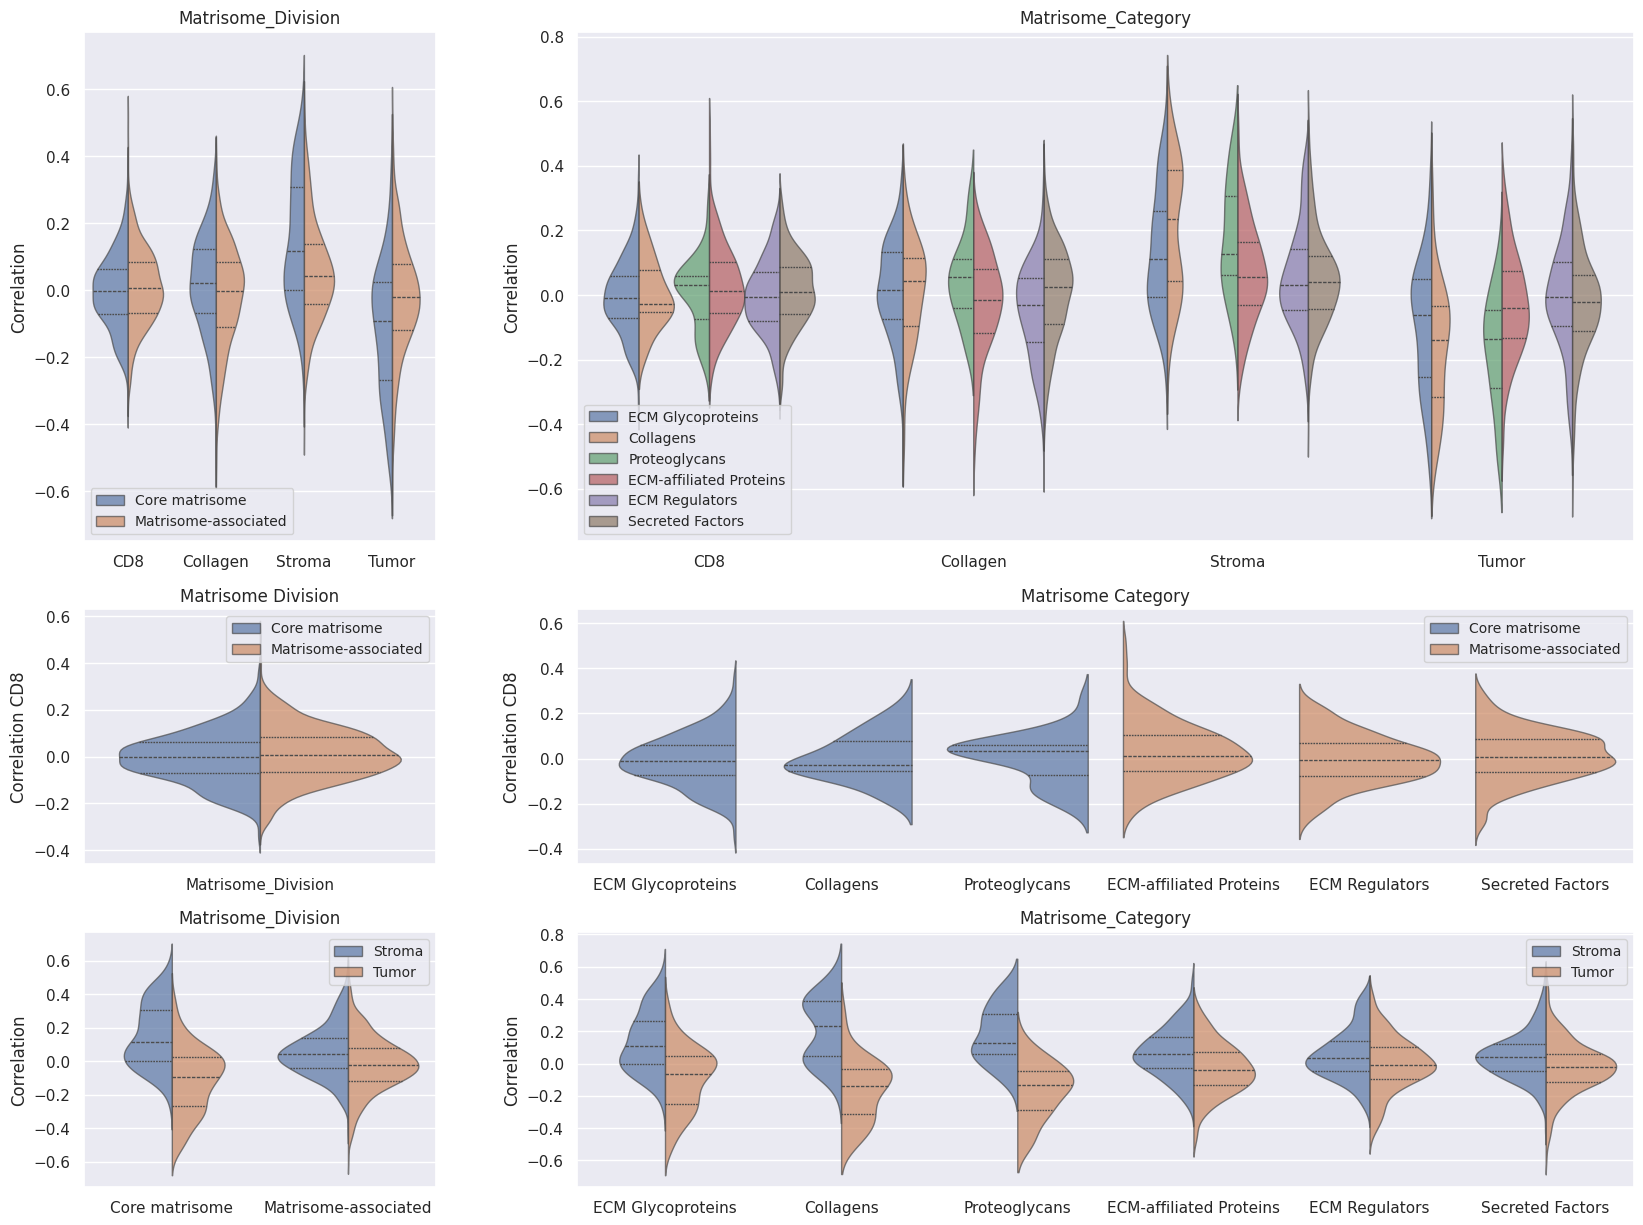

In [11]:
# Draw a violin plot of the correlation values for each Matrisome Division and Matrisome Category
fig, ax = plt.subplots(3, 2, figsize=(20, 15), gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [2, 1, 1]})
sns.violinplot(x="Staining", y="Correlation", data=corr_staining, hue="Matrisome_Division", ax=ax[0, 0], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[0, 0].set_title("Matrisome_Division")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("Correlation")
ax[0, 0].tick_params(axis='x')
ax[0, 0].legend(loc='lower left', fontsize='small')

sns.violinplot(x="Staining", y="Correlation", data=corr_staining, hue="Matrisome_Category", ax=ax[0, 1], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[0, 1].set_title("Matrisome_Category")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("Correlation")
ax[0, 1].tick_params(axis='x')
ax[0, 1].legend(loc='lower left', fontsize='small')

sns.violinplot(x="Matrisome_Division", y="CD8", data=corr_division, ax=ax[1, 0], alpha=0.7, hue="Division", split=True, inner="quart", linewidth=1)
ax[1, 0].set_title("Matrisome Division")
ax[1, 0].set_xlabel("")
ax[1, 0].set_ylabel("Correlation CD8")
ax[1, 0].tick_params(axis='x')
ax[1, 0].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Category", y="CD8", data=corr_division, ax=ax[1, 1], alpha=0.7, hue="Division", split=True, inner="quart", linewidth=1)
ax[1, 1].set_title("Matrisome Category")
ax[1, 1].set_xlabel("")
ax[1, 1].set_ylabel("Correlation CD8")
ax[1, 1].tick_params(axis='x')
ax[1, 1].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Division", y="Correlation", data=corr_tumor_stroma, hue="Staining", ax=ax[2, 0], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[2, 0].set_title("Matrisome_Division")
ax[2, 0].set_xlabel("")
ax[2, 0].set_ylabel("Correlation")
ax[2, 0].tick_params(axis='x')
ax[2, 0].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Category", y="Correlation", data=corr_tumor_stroma, hue="Staining", ax=ax[2, 1], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[2, 1].set_title("Matrisome_Category")
ax[2, 1].set_xlabel("")
ax[2, 1].set_ylabel("Correlation")
ax[2, 1].tick_params(axis='x')
ax[2, 1].legend(loc='upper right', fontsize='small')

plt.show()

# Find the highest correlated and anti-correlated genes with CD8

In [12]:
# Find the top genes with the highest correlation with CD8
top_genes = matrisome_genes.nlargest(20, 'CD8')
top_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
411,ENSG00000172016,REG3A,Matrisome-associated,ECM-affiliated Proteins,0.518755,0.000007,0.006907,0.141137,0.254606,0.738138,0.097804,0.431055,0.834658,-0.111431,0.369325,0.758923
303,ENSG00000090659,CD209,Matrisome-associated,ECM-affiliated Proteins,0.437446,0.000214,0.107428,0.104529,0.399894,0.830718,0.150983,0.222619,0.636144,-0.175295,0.155940,0.506175
341,ENSG00000164035,EMCN,Matrisome-associated,ECM-affiliated Proteins,0.385021,0.001294,0.432748,0.133113,0.282885,0.757606,0.107347,0.387237,0.810480,-0.171812,0.164457,0.521994
91,ENSG00000153902,LGI4,Core matrisome,ECM Glycoproteins,0.355713,0.003136,0.786274,-0.014850,0.905059,0.968369,-0.005148,0.967021,0.992856,0.001564,0.989976,0.997480
974,ENSG00000120057,SFRP5,Matrisome-associated,Secreted Factors,0.307742,0.011297,0.995823,0.043813,0.724805,0.951768,-0.037841,0.761111,0.960244,-0.100770,0.417147,0.793291
922,ENSG00000186715,MST1L,Matrisome-associated,Secreted Factors,0.307509,0.011362,0.995823,0.055969,0.652811,0.938731,0.023714,0.848932,0.981147,-0.187369,0.128939,0.452188
410,ENSG00000172023,REG1B,Matrisome-associated,ECM-affiliated Proteins,0.292986,0.016123,0.995823,0.143065,0.248109,0.734212,0.017503,0.888198,0.987368,-0.102469,0.409294,0.784305
135,ENSG00000189056,RELN,Core matrisome,ECM Glycoproteins,0.280793,0.021355,0.995823,0.234632,0.055982,0.456505,0.171257,0.165845,0.547605,-0.186617,0.130510,0.455386
727,ENSG00000137077,CCL21,Matrisome-associated,Secreted Factors,0.276975,0.023265,0.995823,0.046571,0.708232,0.951768,0.034983,0.778675,0.969822,-0.099390,0.423583,0.797100
863,ENSG00000169194,IL13,Matrisome-associated,Secreted Factors,0.273570,0.025088,0.995823,0.010147,0.935050,0.981817,-0.052907,0.670683,0.922466,-0.065875,0.596360,0.905158


In [13]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = matrisome_genes.nsmallest(20, 'CD8')
bottom_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
99,ENSG00000132031,MATN3,Core matrisome,ECM Glycoproteins,-0.337249,0.005258,0.995823,0.142628,0.249573,0.735549,0.364173,0.002449,0.032693,-0.323846,0.007509,0.078458
1006,ENSG00000135925,WNT10A,Matrisome-associated,Secreted Factors,-0.313894,0.009690,0.995823,0.050253,0.686320,0.940409,-0.066230,0.594382,0.892829,0.055909,0.653162,0.914949
767,ENSG00000145824,CXCL14,Matrisome-associated,Secreted Factors,-0.285608,0.019138,0.995823,-0.223069,0.069605,0.495130,0.051016,0.681810,0.928658,-0.129170,0.297516,0.689165
618,ENSG00000104368,PLAT,Matrisome-associated,ECM Regulators,-0.282454,0.020567,0.995823,-0.374642,0.001787,0.115006,0.120527,0.331280,0.772715,0.022750,0.855006,0.968727
871,ENSG00000150782,IL18,Matrisome-associated,Secreted Factors,-0.276757,0.023378,0.995823,-0.263542,0.031174,0.373331,-0.023054,0.853090,0.981249,0.209970,0.088119,0.368265
457,ENSG00000008277,ADAM22,Matrisome-associated,ECM Regulators,-0.273963,0.024872,0.995823,0.097634,0.431863,0.843759,0.371373,0.001974,0.027943,-0.273506,0.025123,0.177933
971,ENSG00000104332,SFRP1,Matrisome-associated,Secreted Factors,-0.270372,0.026909,0.995823,0.178352,0.148737,0.668982,0.233223,0.057516,0.285585,-0.147395,0.233934,0.624863
956,ENSG00000196154,S100A4,Matrisome-associated,Secreted Factors,-0.269882,0.027198,0.995823,-0.221490,0.071656,0.499144,-0.038099,0.759534,0.959461,0.252809,0.039014,0.213887
872,ENSG00000142224,IL19,Matrisome-associated,Secreted Factors,-0.266861,0.029036,0.995823,-0.176852,0.152238,0.681293,-0.100556,0.418139,0.830983,0.118951,0.337689,0.722178
951,ENSG00000189171,S100A13,Matrisome-associated,Secreted Factors,-0.257880,0.035127,0.995823,-0.304572,0.012212,0.261728,-0.143528,0.246567,0.674393,0.327844,0.006763,0.074538


# Clean the genes
* Foucs on the core matrisome genes
* Remove the low correlated genes with the stroma
* Remove the high correlated genes with the tumor cells

In [14]:
# Remove the secreted factors
df_clean = matrisome_genes[matrisome_genes.Matrisome_Division != "Matrisome-associated"]

# Remove the highly correlated genes with the stroma
df_clean = df_clean[df_clean.Stroma > 0]

# Remove the highly correlated genes with the tumor
df_clean = df_clean[df_clean.Tumor < 0]

In [15]:
# Find the top genes with the highest correlation with CD8
top_genes = df_clean.nlargest(20, 'CD8')
top_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
135,ENSG00000189056,RELN,Core matrisome,ECM Glycoproteins,0.280793,0.021355,0.995823,0.234632,0.055982,0.456505,0.171257,0.165845,0.547605,-0.186617,0.130510,0.455386
239,ENSG00000157766,ACAN,Core matrisome,Proteoglycans,0.268618,0.027955,0.995823,0.100734,0.417315,0.837133,0.210435,0.087401,0.366793,-0.304431,0.012254,0.111736
201,ENSG00000204291,COL15A1,Core matrisome,Collagens,0.253809,0.038220,0.995823,0.231667,0.059249,0.460128,0.538250,0.000003,0.000527,-0.417995,0.000432,0.012237
186,ENSG00000110799,VWF,Core matrisome,ECM Glycoproteins,0.242088,0.048410,0.995823,0.027095,0.827703,0.960361,0.198065,0.108124,0.430351,-0.190689,0.122177,0.439223
138,ENSG00000146374,RSPO3,Core matrisome,ECM Glycoproteins,0.241325,0.049144,0.995823,0.194115,0.115485,0.612866,0.247358,0.043582,0.244206,-0.290600,0.017050,0.141330
170,ENSG00000168477,TNXB,Core matrisome,ECM Glycoproteins,0.213011,0.083509,0.995823,0.288176,0.018038,0.311933,0.251592,0.039997,0.230759,-0.259116,0.034230,0.201957
104,ENSG00000037749,MFAP3,Core matrisome,ECM Glycoproteins,0.207167,0.092544,0.995823,0.041840,0.736734,0.951768,0.085125,0.493398,0.881809,-0.048066,0.699310,0.920742
214,ENSG00000160963,COL26A1,Core matrisome,Collagens,0.190572,0.122410,0.995823,0.097753,0.431299,0.843759,0.076721,0.537183,0.885710,-0.181411,0.141781,0.483696
212,ENSG00000171502,COL24A1,Core matrisome,Collagens,0.190561,0.122432,0.995823,0.013715,0.912288,0.971364,0.335143,0.005566,0.058154,-0.299718,0.013737,0.124131
100,ENSG00000124159,MATN4,Core matrisome,ECM Glycoproteins,0.188472,0.126660,0.995823,-0.024506,0.843951,0.960361,0.005279,0.966181,0.992856,-0.100148,0.420043,0.793415


In [16]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = df_clean.nsmallest(20, 'CD8')
bottom_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
99,ENSG00000132031,MATN3,Core matrisome,ECM Glycoproteins,-0.337249,0.005258,0.995823,0.142628,0.249573,0.735549,0.364173,2.449128e-03,0.032693,-0.323846,0.007509,0.078458
112,ENSG00000173376,NDNF,Core matrisome,ECM Glycoproteins,-0.242920,0.047620,0.995823,-0.036967,0.766473,0.959921,0.171793,1.645050e-01,0.547605,-0.134279,0.278653,0.671848
247,ENSG00000164283,ESM1,Core matrisome,Proteoglycans,-0.221667,0.071423,0.995823,-0.007633,0.951115,0.985611,0.122800,3.221735e-01,0.767554,-0.017237,0.889891,0.969555
61,ENSG00000143341,HMCN1,Core matrisome,ECM Glycoproteins,-0.210686,0.087016,0.995823,0.121326,0.328060,0.789074,0.573272,3.972991e-07,0.000199,-0.542096,0.000002,0.000722
149,ENSG00000262655,SPON1,Core matrisome,ECM Glycoproteins,-0.194433,0.114879,0.995823,-0.018408,0.882456,0.962700,0.400490,7.845205e-04,0.016059,-0.342019,0.004614,0.059185
223,ENSG00000188153,COL4A5,Core matrisome,Collagens,-0.193003,0.117626,0.995823,0.103797,0.403217,0.830934,0.101876,4.120249e-01,0.830983,-0.049782,0.689109,0.920742
270,ENSG00000107742,SPOCK2,Core matrisome,Proteoglycans,-0.190974,0.121609,0.995823,0.005781,0.962971,0.987827,0.278672,2.239826e-02,0.148778,-0.143719,0.245931,0.644045
29,ENSG00000143369,ECM1,Core matrisome,ECM Glycoproteins,-0.188775,0.126041,0.995823,-0.094489,0.446913,0.843759,0.172487,1.627804e-01,0.547605,-0.054101,0.663692,0.918486
85,ENSG00000135862,LAMC1,Core matrisome,ECM Glycoproteins,-0.180552,0.143709,0.995823,-0.211833,0.085272,0.534547,0.198705,1.069652e-01,0.429090,-0.054404,0.661926,0.918486
167,ENSG00000123610,TNFAIP6,Core matrisome,ECM Glycoproteins,-0.172689,0.162281,0.995823,-0.042972,0.729886,0.951768,0.247490,4.346636e-02,0.244206,-0.084312,0.497551,0.859477


# Get the peptide mass
Get a UniProtKB list of protein ids for each gene then get the peptide masses for each protein using ExPASy peptide mass tool.

In [17]:
# Peptides mass path
peptides_mass_path = "data/MALDI_IHC/results/peptides_mass"

# Get the gene names for the top and bottom genes and remove duplicates
genes = pd.concat([top_genes, bottom_genes])['Gene_Symbol'].unique()

# Get the peptide mass for each gene
for gene in genes:
    print(f"\nGene: {gene}")

    # Get a list of protein names for the gene
    protein_names = get_uniprotkbid(gene)
    
    # Get the peptide mass for each protein name
    for protein_name in protein_names:
        print(f"Protein: {protein_name}")

        # Check if the file already exists
        if not os.path.exists(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv"):

            # Get the peptide mass
            peptide_mass = get_expasy_peptide_mass(protein_name)
            print(f"{peptide_mass.shape[0]} peptides")

            # Save the peptide mass to a csv file
            peptide_mass.to_csv(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv", index=False)


Gene: RELN
Protein: RELN_HUMAN
154 peptides

Gene: ACAN
Protein: PGCA_HUMAN
54 peptides

Gene: COL15A1
Protein: COFA1_HUMAN
48 peptides

Gene: VWF
Protein: VWF_HUMAN
44 peptides

Gene: RSPO3
Protein: RSPO3_HUMAN
18 peptides

Gene: TNXB
Protein: TENX_HUMAN
215 peptides

Gene: MFAP3
Protein: MFAP3_HUMAN
24 peptides

Gene: COL26A1
Protein: COQA1_HUMAN
25 peptides

Gene: COL24A1
Protein: COOA1_HUMAN
103 peptides

Gene: MATN4
Protein: MATN4_HUMAN
40 peptides

Gene: SBSPON
Protein: SBSPO_HUMAN
15 peptides

Gene: COL19A1
Protein: COJA1_HUMAN
71 peptides

Gene: RSPO1
Protein: RSPO1_HUMAN
15 peptides

Gene: ELSPBP1
Protein: ESPB1_HUMAN
15 peptides

Gene: FBLN5
Protein: FBLN5_HUMAN
23 peptides

Gene: PRG2
Protein: PRG2_HUMAN
6 peptides
Protein: PXDN_HUMAN
91 peptides
Protein: PLPR3_HUMAN
37 peptides

Gene: COL28A1
Protein: COSA1_HUMAN
81 peptides

Gene: CRISPLD2
Protein: CRLD2_HUMAN
30 peptides

Gene: VWA3B
Protein: VWA3B_HUMAN
103 peptides

Gene: EYS
Protein: EYS_HUMAN
163 peptides

Gene: MATN

# Make a reference of the correlated peptides mass

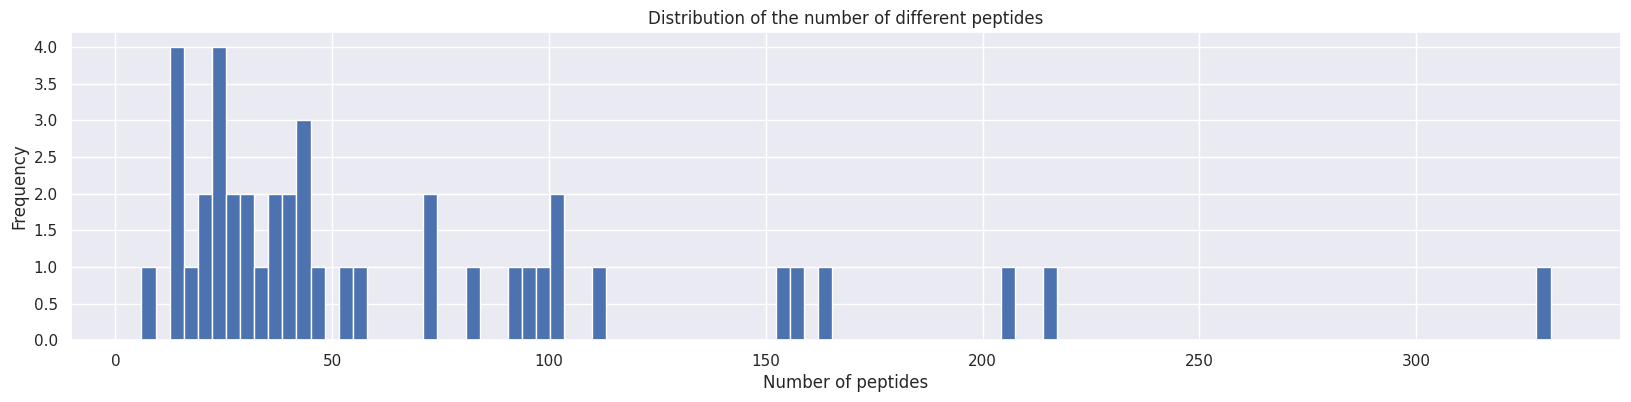

Number of proteins: 42
Number of proteins with less than 100 peptides: 33
Number of proteins with more than 100 peptides: 9


In [18]:
# Extract the protein peptide masses
masses = [pd.read_csv(f"{peptides_mass_path}/{protein}")["mass"] for protein in os.listdir(peptides_mass_path)]

masses_number = [len(mass) for mass in masses]

# Plot the distribution of the peptide masses number
plt.figure(figsize=(20, 4))
plt.hist(masses_number, bins=100)
plt.xlabel("Number of peptides")
plt.ylabel("Frequency")
plt.title("Distribution of the number of different peptides")
plt.show()

print(f"Number of proteins: {len(masses)}")
print(f"Number of proteins with less than 100 peptides: {sum([1 for mass in masses_number if mass < 100])}")
print(f"Number of proteins with more than 100 peptides: {sum([1 for mass in masses_number if mass > 100])}")

In [19]:
# # pool the peptide masses of all the proteins with number of peptides < 100
# masses_pool = np.concatenate([mass for mass in masses if len(mass) < 100])

# pool the peptide masses of all the proteins
masses_pool = np.concatenate(masses)

# Sort the masses pool
masses_pool = np.sort(masses_pool)

# Build a reference of unique masses
unique_masses = np.unique(masses_pool)

print(f"Number of unique masses: {unique_masses.shape[0]}")
print(f"Number of duplicated masses: {masses_pool.shape[0] - unique_masses.shape[0]}")

Number of unique masses: 2731
Number of duplicated masses: 132


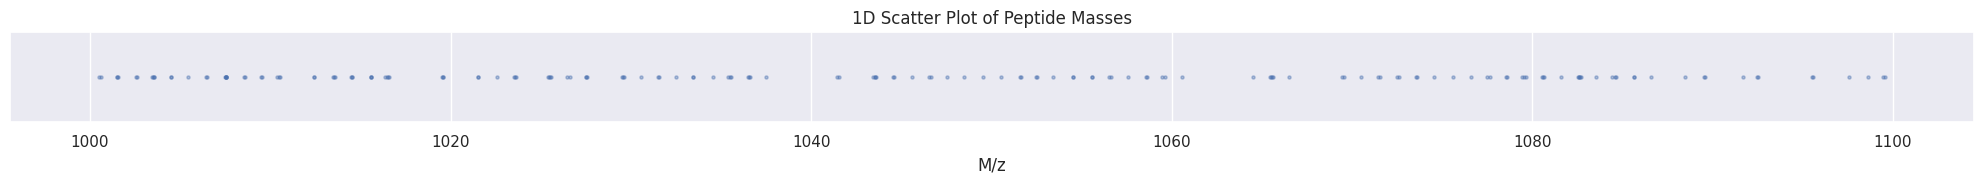

In [20]:
# Sample array of masses
masses_sample = masses_pool[(masses_pool > 1000) & (masses_pool < 1100)] 

plt.figure(figsize=(20, 2), tight_layout=True)
plt.scatter(masses_sample, [0]*len(masses_sample), s=5, alpha=0.4)
plt.xlabel("M/z")
plt.title("1D Scatter Plot of Peptide Masses")
plt.yticks([])
plt.show()

In [21]:
# Save the unique masses to a csv file
pd.DataFrame(unique_masses, columns=["mass"]).to_csv("data/MALDI_IHC/results/correlated_masses_reference.csv", index=False)